In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2DTranspose, Conv2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import time

2024-01-09 08:57:38.143495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 08:57:38.143656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 08:57:38.315249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 08:57:38.677445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 08:57:40.777614: W tensorflow/compiler/tf2

# Load the MNIST data
We want to generate numbers and we dont care which number. Therefor we olny want the training images

In [4]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data() # get only train images (skip labels and test images)

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [7]:
# crate dataset to enable batching since can not use .fit()
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(64) # images are in a long list thus from_tensor_slices()

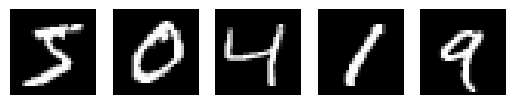

In [8]:
for batch in train_dataset:
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(batch[i], cmap='gray')
        plt.axis('off')
    plt.show()
    break  # Break after the first batch


# Generator model

In [9]:
def build_generator(noise_dim): # noise dim ensures that each generated image is uniqe (too small resuls in the same image, too large requires more comp power)
    model = Sequential()

    # upbyggnaden av bilden är flexibel fram till sista lagret
    # NOTE: using Transpose layers to build up image (fewer filters and larger image)
    model.add(Dense(64 * 7 * 7, activation="relu", input_dim=noise_dim))
    model.add(Reshape((7, 7, 64)))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same")) # -> shape 14, 14, 32 (padding 'same' => output shape = input shape * stride)
    model.add(Activation("sigmoid"))
    model.add(Conv2DTranspose(16, kernel_size=4, strides=2, padding="same")) # -> shape 28, 28, 16 (padding 'same' => output shape = input shape * stride)
    model.add(Activation("sigmoid"))
    # behåll detta lager oförändat
    # NOTE: last layer is Conv
    model.add(Conv2D(1, kernel_size=4, padding="same")) # -> shape 28, 28, 1 ((padding 'same' => output shape = input shape / stride)); padding 'valid' would give 25, 25, 1
    model.add(Activation("tanh"))

    return model

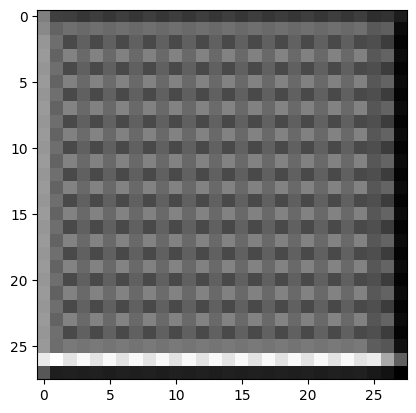

In [10]:
# Crate 1 test image
generator = build_generator(20) # för smått ger samma bild om och om, större kräver längre tid
noise = tf.random.normal([1, 20]) # vector with the noise_dim size to introduce randominess in image generation; 1 is batchsize which here is 1 image

generated_image = generator(noise, training=False)
plt.imshow(generated_image[0], cmap='gray')

In [15]:
generated_image.shape

TensorShape([1, 28, 28, 1])

---
---
### Extra: investigate generator

In [11]:
print(noise)

tf.Tensor(
[[ 0.05996788 -0.57591814  1.1551961   1.4691479   0.39045838  0.71343476
  -0.20936336 -1.1882329  -0.2493439  -1.4659169   0.01399873  1.3693498
  -0.26757243 -0.5256968  -1.8003777   0.1693137   1.1290667  -0.36692944
   0.00688675 -0.9819817 ]], shape=(1, 20), dtype=float32)


In [12]:
type(generator)

keras.src.engine.sequential.Sequential

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              65856     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        32800     
 anspose)                                                        
                                                                 
 activation (Activation)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        8208      
 Transpose)                                                      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 16)        0

In [14]:
generator.layers

In [22]:
generator.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(20, 3136) dtype=float32, numpy=
 array([[-0.01319658,  0.01803543, -0.03406855, ..., -0.00848823,
         -0.01314159,  0.00577255],
        [ 0.02314151, -0.03394462,  0.02840214, ...,  0.01238343,
          0.03588814, -0.02507965],
        [-0.03741555, -0.02489019,  0.03919011, ..., -0.01932982,
         -0.02995517,  0.01204212],
        ...,
        [-0.03991327, -0.00449719,  0.02340788, ..., -0.02820086,
         -0.0433743 , -0.00434995],
        [ 0.01097751,  0.00677216, -0.02756534, ...,  0.00755903,
         -0.00241226,  0.02272692],
        [ 0.04350678, -0.00548652,  0.00298585, ..., -0.04205829,
          0.01778521,  0.01584218]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(3136,) dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Variable 'conv2d_transpose/kernel:0' shape=(4, 4, 32, 64) dtype=float32, numpy=
 array([[[[ 1.53479278e-02,  5.29629737e-02,  2.85616666e-02, ...,
           -4.661

---
---

# Dicriminator model

In [10]:
# classifier
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=image_shape)) # 28, 28, 1 -> shape 14, 14, 64 ((padding 'same' => output shape = input shape / stride))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same")) # -> shape 7, 7, 128 ((padding 'same' => output shape = input shape / stride))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten()) # size 7 * 7 * 128 thus shape (6272, )
    model.add(Dense(1, activation='sigmoid'))

    return model

In [1]:
current_dir = "./"
current_dir

'./'

In [11]:
# classify the gererated test image
discriminator = build_discriminator((28,28,1))
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5025318]], shape=(1, 1), dtype=float32)


# Loss functions and optimizers

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # 2 klasser Fake/Real #from_logits=True ger ut väden - inf till inf instället för probs, vilket också skulle funka här

In [13]:
# labels are created in the loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # result from model on real images: true labels always 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # result from model on fake images: true labels always 0
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    # We want the dicriminator to think all fake images are correct.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Train the models

In [ ]:
# https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

@tf.function # går snabbare
def train_step(images, noise_dim): # kör genom 1 batch (här på 64 bilder), uppdaterar, nästa batch, uppdaterar osv till slutet av datasettet
    noise = tf.random.normal([64, noise_dim]) # 64 to match batchsize of 64 defined above

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # for gradient calculations
        # generate fake images as many as in the batch
        generated_images = generator(noise, training=True) # training = True does not improve image gen but uses for example Dropout layers if present in model (which would not be used in Training = False)
        
        # forward passes on the batches of images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    # calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # same as model.trainable_weights
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update trainable variables with calculated gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # create pairs of gradient and corresponding trainable variables elementwise
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # return disc_loss, gen_loss, generated_images
    # NOTE: dics_loss and gen_loss does not say much as they are dependant on each other. Low gen_loss if discriminator is poor in not an atchevement...


In [17]:
def show_generated_image(generator, noise_dim):
    # Generate random noise as input
    noise = np.random.normal(0, 1, (1, noise_dim)) # (mean, stdev, dimensions); could inclde returning generated_images from train_step and just plot generated_images[0] for an example

    # Generate an image from the noise
    generated_image = generator.predict(noise)[0]

    # Plot the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [18]:
def train(dataset, epochs, noise_dim):
    for epoch in range(epochs):
        start = time.time()
    
        for image_batch in dataset:
            train_step(image_batch, noise_dim)
        
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        # Show generated image
        show_generated_image(generator, noise_dim)


/home/dorota/projects/Deep-Machine-Learning-Dorota-Bjoorn/venv/lib/python3.10/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 194.2801706790924 sec
1/1 [==============================] - 0s 203ms/step


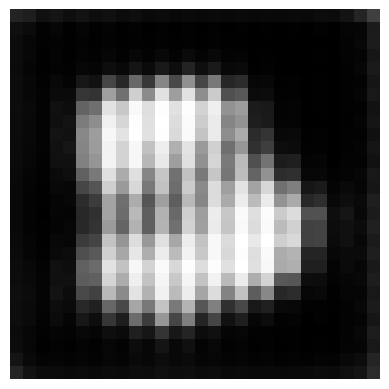

Time for epoch 2 is 184.21483850479126 sec
1/1 [==============================] - 0s 28ms/step


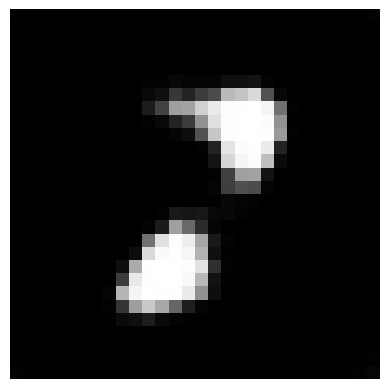

KeyboardInterrupt: 

In [19]:
train(train_dataset, 50, 20)

# Tasks
Change the model architectures and try to generate as good images as possible.

Remember to not only change the generator. If the discriminator gets better, the generator need to generate better images.